# Python y funciones

In [ ]:
!pip install nibabel dipy fury pytest nose
#!sudo apt-get install libeigen3-dev zlib1g-dev libqt5opengl5-dev libqt5svg5-dev libgl1-mesa-dev libfftw3-dev libtiff5-dev libpng-dev
#!git clone https://github.com/MRtrix3/mrtrix3.git
#% cd mrtrix3/
#!./configure
#!./build
#!./set_path

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

volume_path = 'data/NODDI_DWI.nii/NODDI_DWI.nii'
mask_path = 'data/BRAIN_MASK.nii/BRAIN_MASK.nii'
scheme_path = 'data/NODDI_DWI.scheme'
dbf_orientations_path = 'data/DBF_129orientations.dat'
dwi_data_path = 'Sujeto1_DWI_data.mif'

import os

os.chdir("/content/drive/My Drive/Colab Notebooks/imagenes_biomedicas/")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Funciones auxiliares

In [ ]:
import numpy as np
import math

def get_bval_from_others(G, DELTA, delta, scale=True):
    gmr = 2 * np.pi * 42.576 * 1e6 # (rad)/(sec T)
    bval = gmr**2 * G**2 * delta**2 * (DELTA - (delta / 3)) # sec/m^2
    if scale : 
        bval = bval * 1e-6
    return bval

#### Funciones para lectura de archivos

In [ ]:
def get_bvals_bvecs(scheme_path):
    """
    Archivo con parametro de adquisision en formato:
    VERSION: STEJSKALTANNER
    g_x    g_y    g_z    G(Tesla/Metro)    DELTA    delta    TE
    ...
    g_x    g_y    g_z    G(Tesla/Metro)    DELTA    delta    TE
    """
    scheme_file = open(os.getcwd() + '/' + scheme_path, "r")

    bvals = []
    bvecs = []
    print(scheme_file.readline())
    for line in scheme_file:
        # Lectura de parametros de maquina
        g_x,g_y,g_z,G,delta,DELTA,TE = [np.float64(val) for val in line.split()]
        # Vectores g_i y magnitud b_i
        bvals.append(get_bval_from_others(G, DELTA, delta, False))
        bvecs.append([g_x, g_y, g_z])

    bvals = np.array(bvals, dtype=np.float64)
    bvecs = np.array(bvecs, dtype=np.float64)

    # Pasamos a escala (sec / mm^2) para DIPY
    bvals = bvals * 1e-6

    return bvals, bvecs

def read_shells(dbf_orientations_path):
    """
    Archivo de direcciones (shell) en formato:
        n_x    n_y    n_z
    """
    dbf_orientations_file = open(os.getcwd() + '/' + dbf_orientations_path, "r")

    nvecs = []
    for line in dbf_orientations_file:
        # Lectura de parametros de maquina
        n_x,n_y,n_z = [np.float64(val) for val in line.split()]
        # Vectores g_i y magnitud b_i
        nvecs.append([n_x, n_y, n_z])
    nvecs = np.array(nvecs, dtype=np.float64)

    return nvecs

#### Funciones para rotaciones

In [ ]:
def rotation_matrix_from_vectors(vec1, vec2):
    """ Find the rotation matrix that aligns vec1 to vec2
    :param vec1: A 3d "source" vector
    :param vec2: A 3d "destination" vector
    :return mat: A transform matrix (3x3) which when applied to vec1, aligns it with vec2.
    """
    a, b = (vec1 / np.linalg.norm(vec1)).reshape(3), (vec2 / np.linalg.norm(vec2)).reshape(3)
    v = np.cross(a, b)
    c = np.dot(a, b)
    s = np.linalg.norm(v)
    if s == 0.0 : # Parallel
        return np.identity(3)
    kmat = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
    rotation_matrix = np.eye(3) + kmat + kmat.dot(kmat) * ((1 - c) / (s ** 2))
    return rotation_matrix

def random_three_vector():
    """
    Generates a random 3D unit vector (direction) with a uniform spherical distribution
    Algo from http://stackoverflow.com/questions/5408276/python-uniform-spherical-distribution
    :return:
    """
    phi = np.random.uniform(0,np.pi*2)
    costheta = np.random.uniform(-1,1)

    theta = np.arccos( costheta )
    x = np.sin( theta) * np.cos( phi )
    y = np.sin( theta) * np.sin( phi )
    z = np.cos( theta )
    return (x,y,z)

#### Funciones para diccionario

In [ ]:
def base_tensor(dkifit):
    # Indices de voxeles con elipsoides cigarro
    volume_indices = (dkifit.fa > 0.7)

    # Medias de eigenvalores \lamda_1, \lambda_2 y \lambda_3 
    evals_mean = np.mean(dkifit.evals[ volume_indices ], axis=0)

    # Eigenvalor \lambda_1 en la direccion paralela a axones
    eval_parallel = evals_mean[0]
    # Promedio de los eigenvalores asociados a direcciones 
    # ortogonales se usa para direcciones ortogonales a axones
    eval_orthogonal = evals_mean[1:3].mean()

    # Tensor de difusion base
    D_x = np.diag([
        eval_parallel, 
        eval_orthogonal,
        eval_orthogonal
    ])
    return D_x

def get_Phi(D_x, b, bvecs, nvecs):
    # Tamanio de la base y numero de gradientes (Columnas, Filas)
    n_basis = nvecs.shape[0]
    n_grad = bvecs.shape[0]

    print('Magnitud b = ' + str(b))
    print('Dimensones del diccionario: ('+ str(n_grad)+','+str(n_basis)+')')
    
    # Eje x como direccion base
    xaxis = np.array([1.0, 0.0, 0.0], dtype=np.float64)
    
    Phi = np.zeros((n_grad, n_basis))

    for j, n in enumerate(nvecs):   
        rotation = rotation_matrix_from_vectors(xaxis, n)
        D_o = rotation @ D_x @ rotation.T
        for i, g_i in enumerate(bvecs):
            D = np.sum(g_i.T.dot(D_o) * g_i)
            Phi[i, j] = np.exp(-b*D)
    
    return Phi

# Datos

## Lectura de volumen, tabla de gradientes y shell

In [ ]:
""" Carga de datos y otros valores """
from dipy.io.image import load_nifti
import numpy as np

# Lectura de volumen de RM y Mascara
data, affine = load_nifti(os.getcwd() + '/' + volume_path)
mask, affine = load_nifti(os.getcwd() + '/' + mask_path)
# Lectura de direcciones y magnitudes de gradiente
bvals, bvecs = get_bvals_bvecs(scheme_path)
# Lectura de direcciones de Shell
nvecs = read_shells(dbf_orientations_path)

# (128, 128, 50, 1, 81) -> (128, 128, 50, 81)
data = data.squeeze()

VERSION: STEJSKALTANNER



## Supresión de ruido

In [ ]:
""" Eliminnacion de ruido ( como en tutorial Dipy )"""
from scipy.ndimage.filters import gaussian_filter

fwhm = 1.25
gauss_std = fwhm / np.sqrt(8 * np.log(2)) # converting fwhm to Gaussian std
data_smooth = np.zeros(data.shape)
for v in range(data.shape[-1]):
    data_smooth[..., v] = gaussian_filter(data[..., v], sigma=gauss_std)

## Modelo con Curtosis

In [ ]:
""" Ajuste de modelo con Curtosis """
from dipy.core.gradients import gradient_table
import dipy.reconst.dki as dki

gtab = gradient_table(bvals, bvecs)
dkimodel = dki.DiffusionKurtosisModel(gtab)
dkifit = dkimodel.fit(data_smooth, mask=mask)

In [ ]:
""" Calculo de Fractional Anisotropy (FA) """
FA = dkifit.fa
FA[np.isnan(FA)] = 0
FA = np.clip(FA, 0, 1)

In [ ]:
""" Calculo de Mean Kurtosis (MK)  """
MK = dkifit.mk(0, 3)

In [ ]:
""" Tensores de Curtosis """
KT = dkifit.kt
KT.shape

(128, 128, 50, 15)

In [ ]:
from dipy.io.image import save_nifti
#save_nifti('FA.nii.gz', FA.astype(np.float32), affine)
#save_nifti('MK.nii.gz', MK.astype(np.float32), affine)
#save_nifti('KT.nii.gz', KT.astype(np.float32), affine)

# Diffusion Basis Functions

### Estimación de $S_0$ y selección de $S_i$'s

In [ ]:
# Lista de magnitudes de shells
b = np.unique(gtab.bvals)

# Indices de imagenes S_0
s_0_indices = (gtab.bvals == b[0])
s_0_volume = data_smooth[ : , : , : , s_0_indices]
# Volumen S_0 promedio enmascarado
S_0 = s_0_volume.transpose()
S_0 = S_0.sum(axis=0).transpose()

# Indices de imagenes S_i
s_b_indices = (gtab.bvals == b[2])
s_b_volume = data_smooth[ : , : , : , s_b_indices]

### Diccionario

In [ ]:
""" Construccion de Tesor de difusion base y diccionario"""
D_x = base_tensor(dkifit)
Phi = get_Phi(D_x, b[2], gtab.bvecs[s_b_indices,:], nvecs)

n_grad, n_vecs = Phi.shape

Magnitud b = 2014.270094062053
Dimensones del diccionario: (48,129)


### Diffusion Bassis Functions

* Obtenemos índices de voxeles con un valor de FA > 0.3
* Obtenemos índices de voxeles con exceso de curtosis

In [ ]:
slices_sagital, slices_coronal, slices_axial, n_grad = s_b_volume.shape

fa_indices = (FA > 0.30) # Usamos voxeles que no parezcan esferas
mk_indices = (MK > 1.00) # Indices con exceso de curtosis

A continuación se presenta una tajada del volumen despues de la umbralizacion en FA (Columna izquirda) y por otro lado, el volumen despues de umbralizar con MK (Columna derecha).

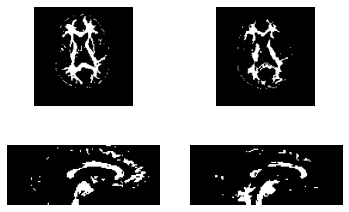

In [ ]:
import matplotlib.pyplot as plt
from dipy.core.histeq import histeq

# Axial
plt.figure('Brain segmentation')
plt.subplot(2, 2, 1).set_axis_off()
plt.imshow(histeq(fa_indices[:,:,slices_axial // 2].astype('float')).T,
           cmap='gray', origin='lower')
plt.subplot(2, 2, 2).set_axis_off()
plt.imshow(histeq(mk_indices[:,:,slices_axial // 2].astype('float')).T,
           cmap='gray', origin='lower')


plt.subplot(2, 2, 3).set_axis_off()
plt.imshow(histeq(fa_indices[slices_sagital // 2,:,:].astype('float')).T,
           cmap='gray', origin='lower')
plt.subplot(2, 2, 4).set_axis_off()
plt.imshow(histeq(mk_indices[slices_sagital // 2,:,:].astype('float')).T,
           cmap='gray', origin='lower')
plt.show()

In [ ]:

### Usamos lasso y nnls (Obtengo resultados muy parecidos)


from scipy.optimize import nnls
from sklearn import linear_model

alphas_nnls = np.zeros((slices_sagital, slices_coronal, slices_axial, n_vecs))
alphas_lasso = np.zeros((slices_sagital, slices_coronal, slices_axial, n_vecs))

for x in range(slices_sagital):
    for y in range(slices_coronal):
        for z in range(slices_axial):
            if fa_indices[x,y,z] :
                
                s_0 = S_0[x,y,z]
                S = s_b_volume[x,y,z,:]
                
                clf = linear_model.Lasso( 
                    fit_intercept=False, 
                    positive=True,
                    alpha=1.0 # que alpha usar?
                )
                alpha = clf.fit(Phi * s_0, S)
                alphas_lasso[x,y,z,:] = alpha.coef_
                
                alphas_nnls[x,y,z,:], _ = nnls(Phi * s_0, S)

Se truncaron las últimas líneas 5000 del resultado de transmisión.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 77594.77571837779, tolerance: 5222.9301000000005
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17690.569713145953, tolerance: 450.58770000000004
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10083.382784084068, tolerance: 2734.8719
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want 

In [ ]:
#save_nifti('alphas_lasso_0.3fa.nii.gz', alphas_lasso.astype(np.float32), affine)
#save_nifti('alphas_nnls.0.3fa.nii.gz', alphas_nnls.astype(np.float32), affine)

### Resultados

A continuación se presentan tajadas del volumen umbralizadas por FA > 0.3. La columna central pertenece a los voxeles que no tienen forma de esfera (FA > 0.3) y además tienen exceso de curtosis (MK > 1.0). A los costados se encuentran los mismos voxeles umbralizados por FA y además, su vector $\alpha$ indica la presencia de más de 1 manojo. La columna izquierda pertenece a los resultados obtenidos con Lasso, mientras que la columna derecha pertenece a nnls.


In [ ]:
# Umbralizamos los alpha_j's, obtenemos la cantidad 
# de manojos (Segun nuestra solucion despues del ubralizado)
# y nos quedamos con los voxeles con mas de un manojo
# para  comparar con curtosis posteriormente
alphas_lasso_indices = (np.sum((alphas_lasso > 0.01), axis=3) > 1)
alphas_nnls_indices = (np.sum((alphas_nnls > 0.01), axis=3) > 1)

print(alphas_lasso_indices.shape,alphas_nnls_indices.shape)

(128, 128, 50) (128, 128, 50)


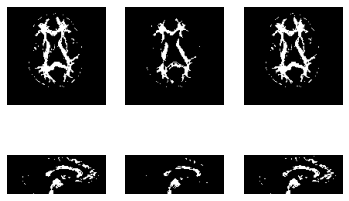

In [ ]:
import matplotlib.pyplot as plt
from dipy.core.histeq import histeq

# Axial
plt.figure('Brain segmentation')
plt.subplot(2, 3, 1).set_axis_off()
plt.imshow(histeq(alphas_lasso_indices[:,:,slices_axial // 2].astype('float')).T,
           cmap='gray', origin='lower')

plt.subplot(2, 3, 2).set_axis_off()
plt.imshow(histeq((mk_indices[:,:,slices_axial // 2]*fa_indices[:,:,slices_axial // 2]).astype('float')).T,
           cmap='gray', origin='lower')

plt.subplot(2, 3, 3).set_axis_off()
plt.imshow(histeq(alphas_nnls_indices[:,:,slices_axial // 2].astype('float')).T,
           cmap='gray', origin='lower')








plt.subplot(2, 3, 4).set_axis_off()
plt.imshow(histeq(alphas_lasso_indices[slices_sagital//2,:,:].astype('float')).T,
           cmap='gray', origin='lower')

plt.subplot(2, 3, 5).set_axis_off()
plt.imshow(histeq((mk_indices[slices_sagital//2,:,:]*fa_indices[slices_sagital//2,:,:]).astype('float')).T,
           cmap='gray', origin='lower')

plt.subplot(2, 3, 6).set_axis_off()
plt.imshow(histeq(alphas_nnls_indices[slices_sagital//2,:,:].astype('float')).T,
           cmap='gray', origin='lower')
plt.show()

### Selección de Tajada

A continuacion seleccionamos una tajada y observamos que los resultados de generar sintéticamente las señales para los diferentes $g_i$'s se parezcan en las zonas que hemos ajusado un $\alpha$.

In [ ]:
""" Seleccion de tajada axial """
slices_sagital, slices_coronal, slices_axial, n_grad = s_b_volume.shape
# Usamos solo una tajada axial
s_axial = s_b_volume[:,:,slices_axial//2,:].transpose()*fa_indices[:,:,slices_axial//2].transpose()
s_axial = s_axial.transpose()

N, M, n_grad = s_axial.shape
S_hat_lasso = np.zeros((N,M,n_grad))
S_hat_nnls = np.zeros((N,M,n_grad))
for x in range(N):
    for y in range(M):
        if fa_indices[x,y,slices_axial//2] :).

            s_0 = S_0[x,y,slices_axial//2]

            S_hat_lasso[x,y,:] = np.matmul(s_0*Phi, alphas_lasso[x,y,slices_axial//2,:])            
            S_hat_nnls[x,y,:] = np.matmul(s_0*Phi, alphas_nnls[x,y,slices_axial//2,:])

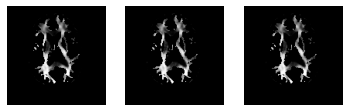

In [ ]:
import matplotlib.pyplot as plt
from dipy.core.histeq import histeq

# Axial
plt.figure('Brain segmentation')

plt.subplot(1, 3, 1).set_axis_off()
plt.imshow(histeq(S_hat_lasso[:,:,0].astype('float')).T,
           cmap='gray', origin='lower')


plt.subplot(1, 3, 2).set_axis_off()
plt.imshow(histeq((s_axial[:,:,0]*fa_indices[:,:,slices_axial // 2]).astype('float')).T,
           cmap='gray', origin='lower')


plt.subplot(1, 3, 3).set_axis_off()
plt.imshow(histeq(S_hat_nnls[:,:,0].astype('float')).T,
           cmap='gray', origin='lower')
plt.show()